In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
stem = '0000/000013'
directory = promonet.CACHE_DIR / 'vctk'
audio = promonet.load.audio(directory / f'{stem}.wav')
pitch = torch.load(directory / f'{stem}-100-viterbi-pitch.pt')
periodicity = torch.load(directory / f'{stem}-100-viterbi-periodicity.pt')

In [4]:
ipd.Audio(audio, rate=promonet.SAMPLE_RATE)

In [64]:
def formants(audio, sample_rate=promonet.SAMPLE_RATE):
    """Extract speech formants via peak picking of LPC coefficients"""
    magnitudes, frequencies, lpc, peaks = [], [], [], []
    
    # Pad
    padding = (promonet.WINDOW_SIZE - promonet.HOPSIZE) // 2
    audio = torch.nn.functional.pad(audio, (padding, padding), 'constant')

    # Chunk
    frames = torch.nn.functional.unfold(
        audio[:, None, None],
        kernel_size=(1, promonet.WINDOW_SIZE),
        stride=(1, promonet.HOPSIZE))[0]

    # Window
    frames = frames.T * torch.hamming_window(promonet.WINDOW_SIZE)

    # Analyze
    for frame in frames:

        # Magnitude FFT
        decibels = torch.log10(torch.abs(torch.fft.fft(frame)))

        # Take real component
        decibels = decibels[0:len(decibels) // 2]
        magnitudes.append(decibels)

        # Get real frequencies
        freqs = (sample_rate / 1000) * torch.linspace(0., 1., 2 * len(decibels))
        freqs = freqs[0:len(freqs) // 2]
        frequencies.append(freqs)

        # LPC analysis
        a = librosa.lpc(frame.numpy(), int((sample_rate / 1000) + 2))
        _, h = scipy.signal.freqz([1], a, worN=len(freqs))

        # Peak picking
        y = torch.log10(torch.abs(torch.tensor(h)))
        peak, _ = scipy.signal.find_peaks(y)
        peaks.append(peak)
        x = torch.mean(y[peak])
        y = y - x
        lpc.append(y)

    return (
        np.array(magnitudes).squeeze(),
        1000 * np.array(frequencies).squeeze(),
        np.array(lpc).squeeze(),
        peaks)

[237.09677, 1228.5923, 2026.0997, 3340.909, 4461.7295, 6854.252, 8039.736, 8707.917, 10518.475]


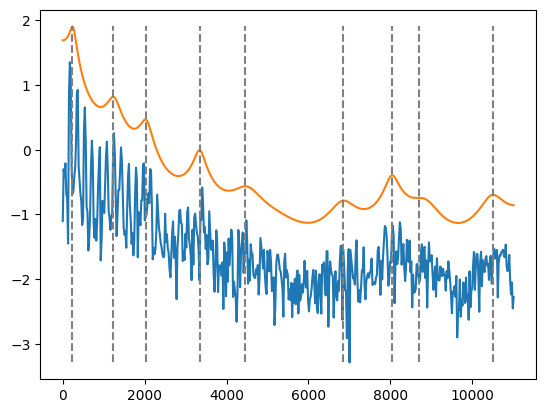

In [65]:
# Plot formants of one frame
magnitudes, frequencies, lpcs, peaks = formants(audio)
index = 90
mag = magnitudes[index]
freq = frequencies[index]
lpc = lpcs[index]
peak = peaks[index]
plt.plot(freq, mag)
plt.plot(freq, lpc)
for p in peak:
    plt.vlines(
        freq[p],
        min(mag.min(), lpc.min()),
        max(mag.max(), lpc.max()),
        color='gray',
        linestyle='--')
print([freq[p] for p in peak])

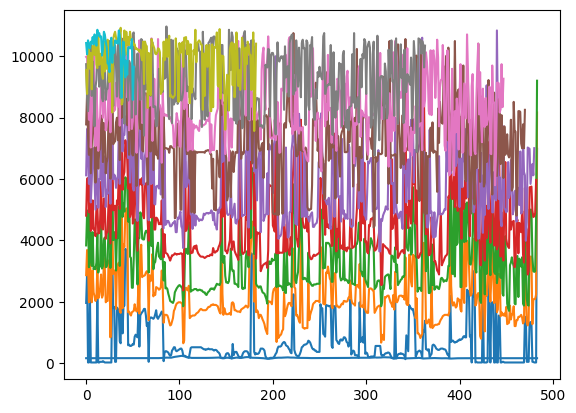

In [73]:
x, y = [], []
formants = {}
for i, (peak, period) in enumerate(zip(peaks, periodicity[0])):
    for j, p in enumerate(sorted(peak)):
        if j >= 10:
            continue
        x.append(i)
        y.append(freq[p])
        try:
            formants[j].append(freq[p])
        except KeyError:
            formants[j] = [freq[p]]
            
for formant in formants.values():
    plt.plot(formant)
plt.plot(pitch.squeeze())

In [67]:
# TODO - compare formants before and after formant shifting
# TODO - formulate a concrete formant metric
# TODO - implement formant metric

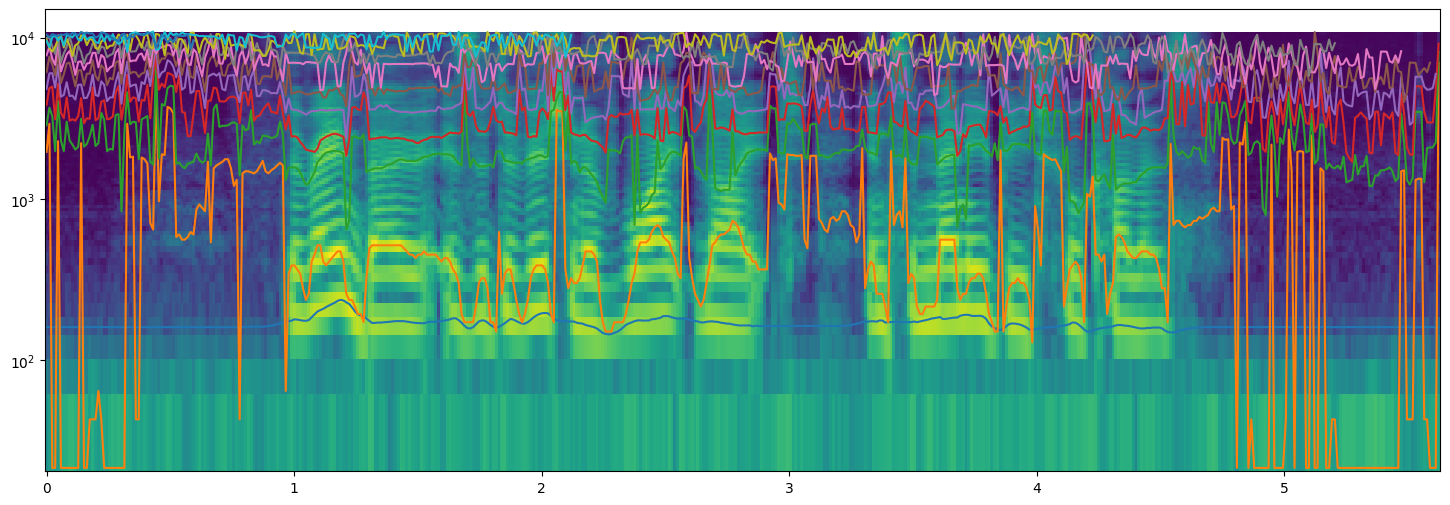

In [77]:
plt.figure(figsize=(18, 6))

# Plot Mels
mels = promonet.preprocess.spectrogram.from_audio(audio, mels=True)
times = np.linspace(0, promonet.convert.samples_to_seconds(audio.shape[-1]), mels.shape[-1])
center_frequencies = librosa.mel_frequencies(promonet.NUM_MELS + 2)[1:-1]
plt.pcolormesh(times, center_frequencies, mels)
plt.yscale('symlog')

# Plot pitch
plt.plot(times, pitch.squeeze())

# Plot formants
for formant in formants.values():
    if len(formant) < len(times):
        formant.extend([None] * (len(times) - len(formant)))
    plt.plot(times, formant)